# Data exploration "Signs of Surveillance" dataset, by Daniel Buzzo
This file covers the exploration of the "Signs of Surveillance" dataset by Daniel Buzzo. In order to make the dataset useable for Object Detection purposes, the dataset is analysed and cleaned where needed. All images in the dataset are 250x250 pixels and were handmade by Daniel Buzzo and are from over 14 countries in the world. For simplicity sake, code has been written to place all the images together in one folder, instead of multiple seperate folders, ordered by country. If you have the SoS dataset in the same directory as this one, this entire EDA should be replicatable.

Fot the purpose of this thesis, the dataset should contain only images that have a clear camera logo in them and should have as few words on them as possible. This is because the other dataset (traffic sign dataset) does not have images with text either and has clear logos on the signs. To make a fair comparisson, both datasets should have as much comparable image quality as possible.

On top of that, removing these images with a lot of text, will also enable this dataset to be used for Image Classification tasks instead of only Object Detection tasks.

Lastly, a small amount of images with an abnormal aspect ratio will also be removed in this file.

In [27]:
# Imports
from PIL import Image
from tqdm import tqdm
import pathlib
import os, os.path
import pandas as pd
import matplotlib.pylab as plt
import random
import pytesseract
import glob
from cv2 import cv2
import numpy as np
import shutil

In [28]:
# Assign path, change to you path where the SoS images are stored
folder_images = os.path.basename("F:\Signs_explore\images")

# Change to the folder you want the compiled dataset to come
new_folder_path = 'F:\Thesis\Signs_explore\cleaning\images'

# Change folder to final cleaning folder
cleaned_path = 'F:\Thesis\Signs_explore\cleaning\cleaned'

In [29]:
# make a folder of all the country codes in the dataset
countries = [pathlib.PurePath(x[0]).name for x in os.walk(folder_images, topdown=False)]
countries

['BE',
 'CND',
 'DE',
 'DK',
 'FR',
 'HK',
 'IT',
 'JP',
 'LU',
 'NL',
 'PT',
 'SE',
 'UAE',
 'UK',
 'USA',
 'images']

In [30]:
# Collect relative paths of all the country codes
country_paths = [x[0] for x in os.walk(folder_images, topdown=False)]

In [31]:
# Function to collect images
def load_images_from_folder(folder):
    images = []
    imagenames = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                images.append(img)
                imagenames.append(filename)
                cv2.imwrite(os.path.join(new_folder_path , filename), img)
    return zip(imagenames, images)

In [32]:
collection = []
for directory in country_paths:
    collection.append(load_images_from_folder(directory))
images = [item for sublist in collection for item in sublist]

## Resolution check
The first step is to see whether all images are indeed 250x250 pixels. If they are not, they should be removed from the dataset, as this can create problems during training of our future model.

In [33]:
# Create dictionary in with the width and heigth of each image
size_images = dict()
for img in images:
    heigth, width, channels = img[1].shape
    size_images[img[0]] = {'width': width, 'heigth': heigth, 'channels':channels}

In [34]:
# Turn to Pandas dataframe
df = pd.DataFrame.from_dict(size_images , orient='index')
df = df.reset_index().rename(columns={"index": "file_Name"})
df

file_Name  width  heigth  channels
0     signs- 1178.jpg    250     250         3
1     signs- 1410.jpg    250     250         3
2     signs- 1411.jpg    250     250         3
3     signs- 1798.jpg    250     250         3
4     signs- 1799.jpg    250     250         3
...               ...    ...     ...       ...
1809   signs- 179.jpg    250     250         3
1810   signs- 180.jpg    250     250         3
1811   signs- 181.jpg    250     250         3
1812   signs- 182.jpg    250     250         3
1813   signs- 183.jpg    250     250         3

[1814 rows x 4 columns]

In [35]:
# Count values to see anomalies in size
df_values = df.value_counts()
df_values

file_Name        width  heigth  channels
signs- 1.jpg     250    250     3           1
signs- 438.jpg   250    250     3           1
signs- 461.jpg   250    250     3           1
signs- 460.jpg   250    250     3           1
signs- 46.jpg    250    250     3           1
                                           ..
signs- 1539.jpg  250    250     3           1
signs- 1538.jpg  250    250     3           1
signs- 1537.jpg  250    250     3           1
signs- 1536.jpg  250    250     3           1
signs- 999.jpg   250    250     3           1
Length: 1814, dtype: int64

In [36]:
# Find names of the images of size anomalies
df_250 = df[(df['width'] != 250) | (df['heigth'] != 250)]
df_250

file_Name  width  heigth  channels
64     signs- 627.jpg    188     250         3
503    signs- 681.jpg    250     188         3
895    signs- 271.jpg    188     250         3
896    signs- 272.jpg    188     250         3
920     signs- 42.jpg    250     235         3
1021  signs- 1532.jpg    188     250         3
1586    signs- 47.jpg    250     188         3
1694   signs- 825.jpg    250     211         3

## Text in images
Now that the images with an abnormal aspect ratio have been removed, it is time to look at the images visualy and get a feeling of what kind of images are currently in the dataset.

In [37]:
def image_gallery(path, images):
    # Function to inspect a random sample of images
    image_list = []
    for filename in glob.glob(path + '/*.jpg'): #assuming gif
        im=Image.open(filename)
        image_list.append(im)

    image_list = random.sample(image_list, images)   
    plt.figure(figsize=(25,25))
    columns = 5
    for i, image in enumerate(image_list):
        plt.subplot(len(image_list) / columns + 1, columns, i + 1)
        plt.imshow(image)

C:\Users\Kishan\AppData\Local\Temp/ipykernel_16388/1203286272.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(image_list) / columns + 1, columns, i + 1)


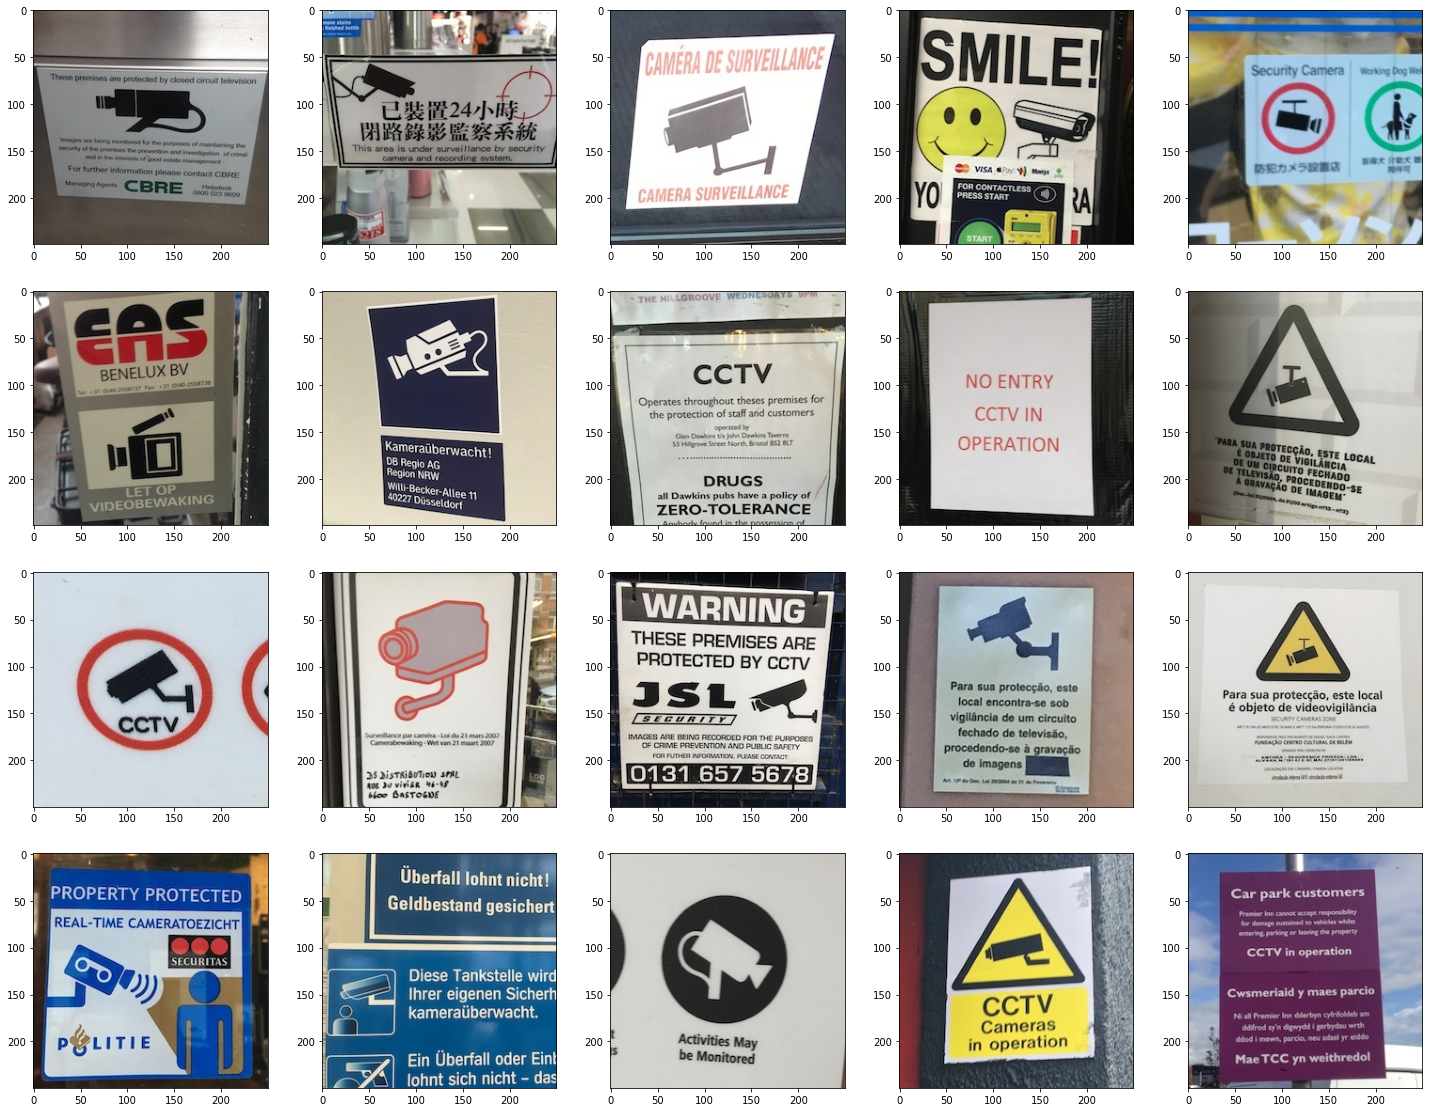

In [38]:
image_gallery(new_folder_path, 20)

### Bad training data analysis
The dataset currently seems to have a lot of images, that have a very small or no camera logo in them. These images are not that useful for training, since they can mess up the results of the Object Detection model that will be used in the future. To find these images, PyTesseract will be used to find the text in images. Three approaches will be used, namely a conservative approach, a middle approach and a rough approach.

The approaches use character counts instead of words counts, because PyTesseract often "glues" words together. One word could actually be five seperate words. Therefore, character counts have been used.

In [40]:
# Change this to your new folder, dont remove the 'r' at the start!
input_dir = r'F:\Thesis\Signs_explore\cleaning\images'

# Change to the location of tesseract.exe
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

In [41]:
def find_text(threshold):
    f, t= [], []
    for root, dirs, filenames in tqdm(os.walk(input_dir)):
        for filename in filenames:
            try: 
                text = pytesseract.image_to_string(input_dir + '/' + filename)
                
                # Threshold 
                if len(text) > threshold:
                    f.append(filename)
                    t.append(text)
            except:
                continue
    return pd.DataFrame(list(zip(f, t)),columns=['file_Name','Text'])

In [42]:
# Conservative approach
df_conservative = find_text(30)

# Middle approach
df_middle = find_text(60)

# Rough approach
df_rough = find_text(90)

1it [04:14, 254.98s/it]
1it [04:00, 240.44s/it]
1it [03:51, 231.93s/it]


In [43]:
# Cleaning the Text columns, by removing interpunction and capitals
df_conservative = df_conservative.replace(r'\n',' ', regex=True) 
df_conservative['Text'] = df_conservative['Text'].replace(r'[^\w\s]','', regex=True).str.lower()

df_middle = df_middle.replace(r'\n',' ', regex=True) 
df_middle['Text'] = df_middle['Text'].replace(r'[^\w\s]','', regex=True).str.lower()

df_rough = df_rough.replace(r'\n',' ', regex=True) 
df_rough['Text'] = df_rough['Text'].replace(r'[^\w\s]','', regex=True).str.lower()

In [44]:
def image_gallery_from_list(df_name, images):
    # Fetching names of all the images regarded to fall under the conservative text threshold
    col_one_list = df_name['file_Name'].tolist()
    
    # Function to inspect a random sample of images
    image_list = []
    for filename in col_one_list: #assuming gif
        im=Image.open(input_dir + '/' + filename)
        image_list.append(im)

    image_list = random.sample(image_list, images)   
    plt.figure(figsize=(25,25))
    columns = 5
    for i, image in enumerate(image_list):
        plt.subplot(len(image_list) / columns + 1, columns, i + 1)
        plt.imshow(image)

### Conservative approach

C:\Users\Kishan\AppData\Local\Temp/ipykernel_16388/2779107500.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(image_list) / columns + 1, columns, i + 1)


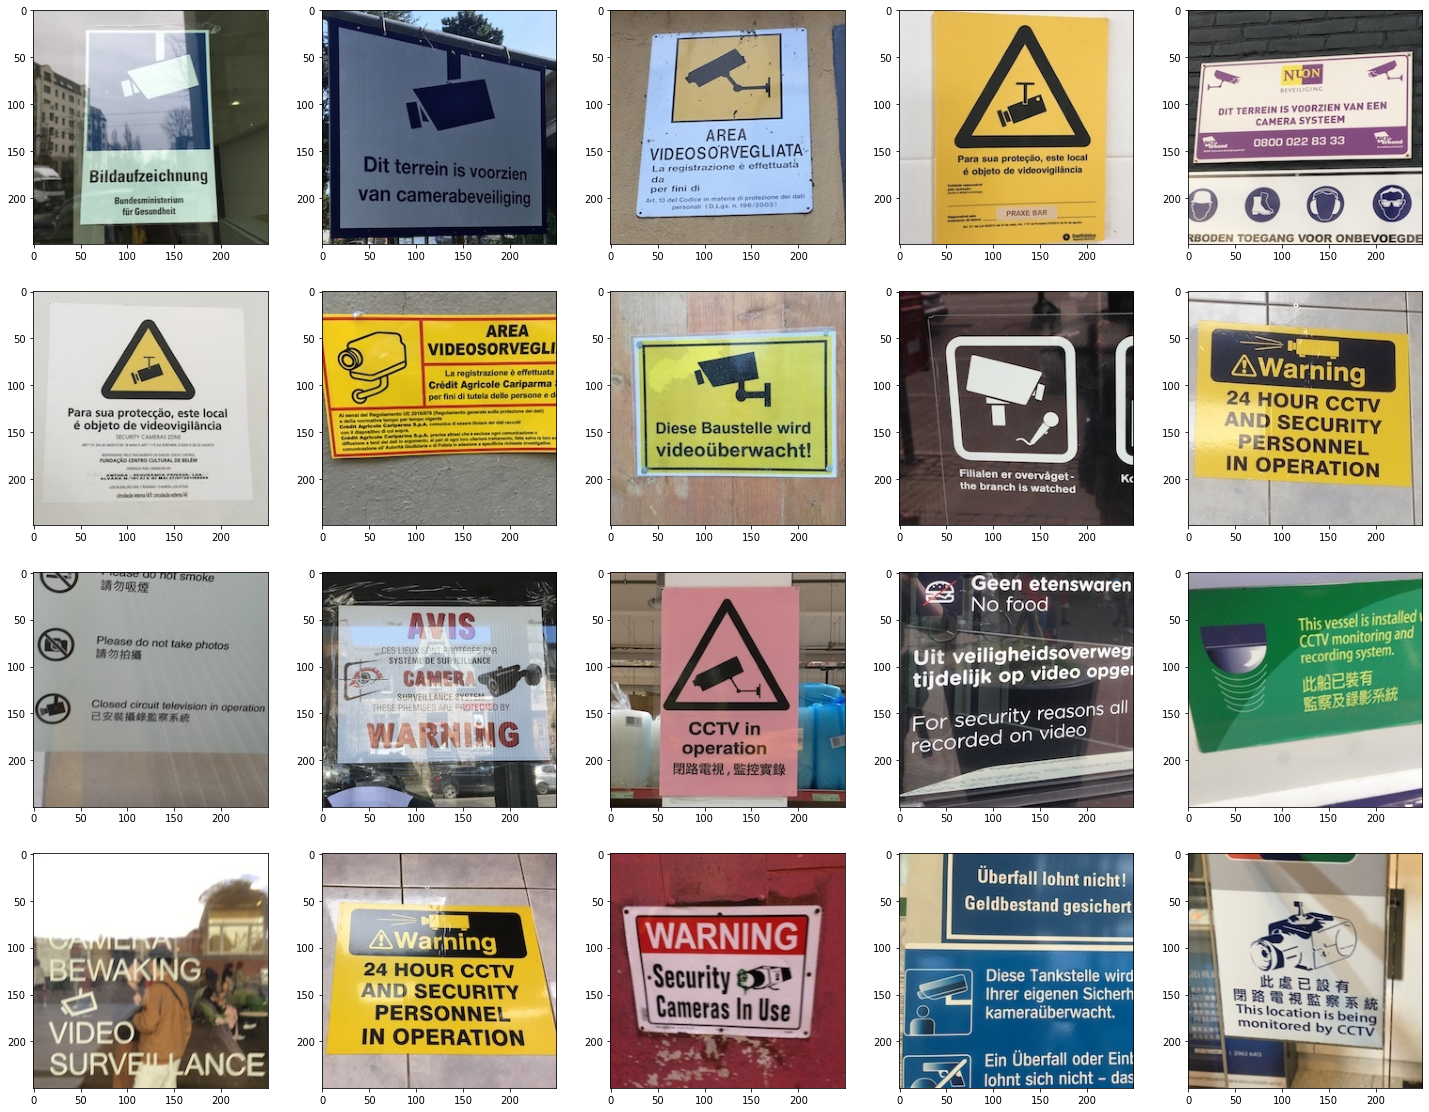

In [45]:
image_gallery_from_list(df_conservative, 20)

### Middle approach

C:\Users\Kishan\AppData\Local\Temp/ipykernel_16388/2779107500.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(image_list) / columns + 1, columns, i + 1)


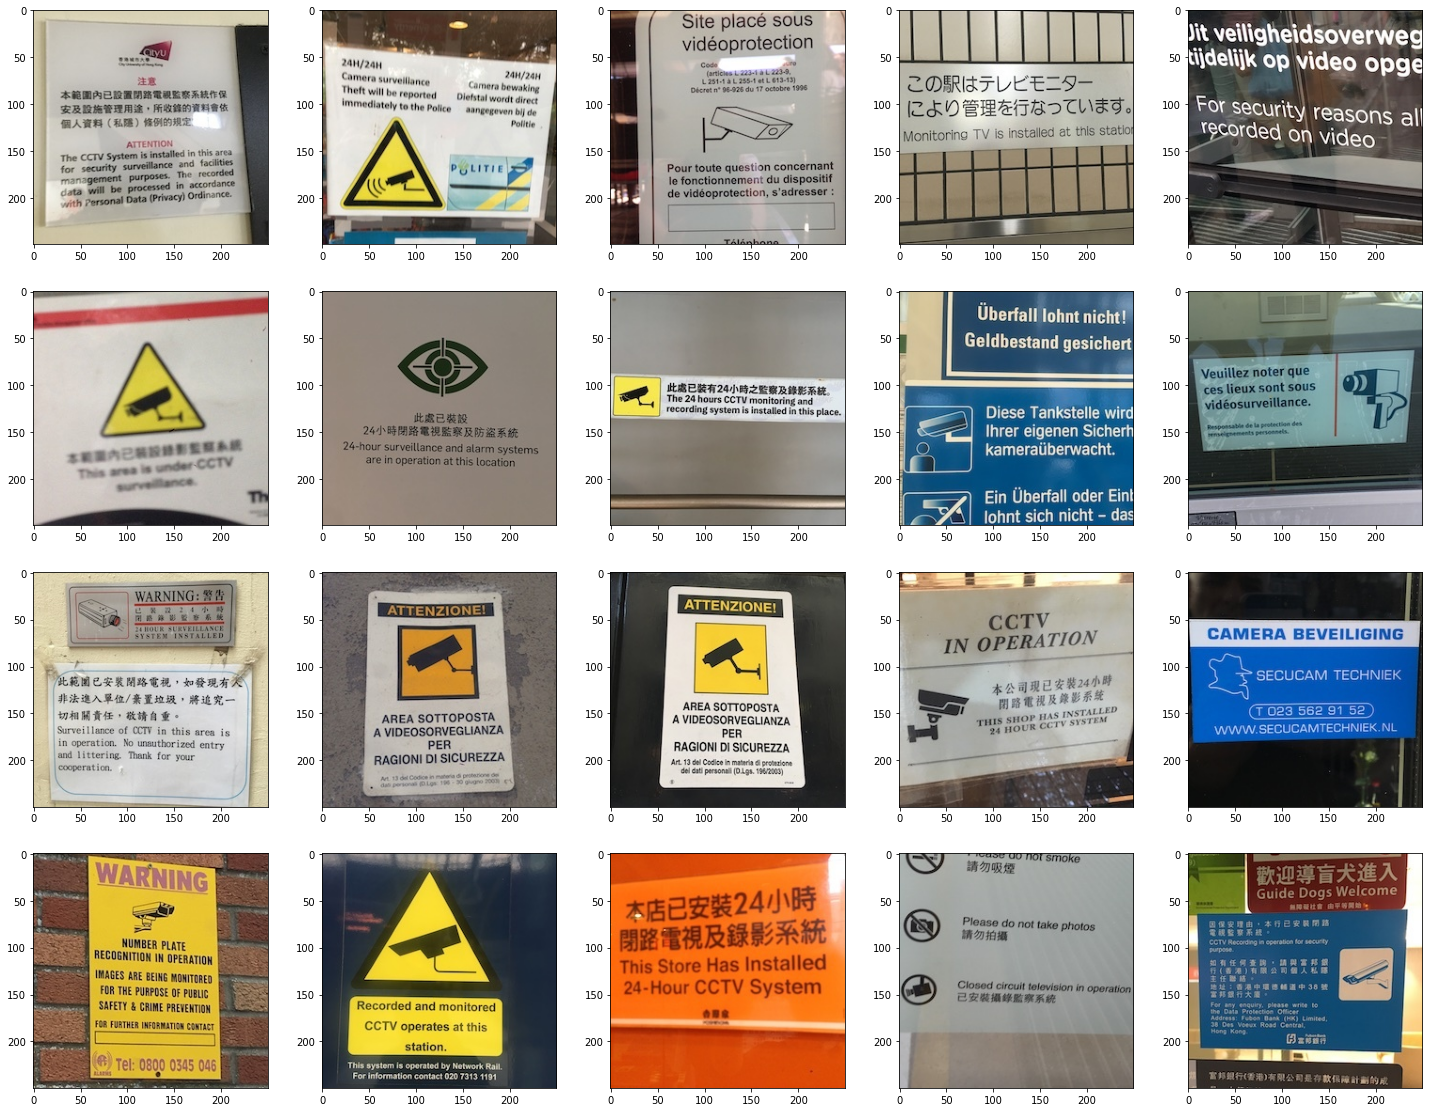

In [46]:
image_gallery_from_list(df_middle, 20)

### Rough approach

C:\Users\Kishan\AppData\Local\Temp/ipykernel_16388/2779107500.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(image_list) / columns + 1, columns, i + 1)


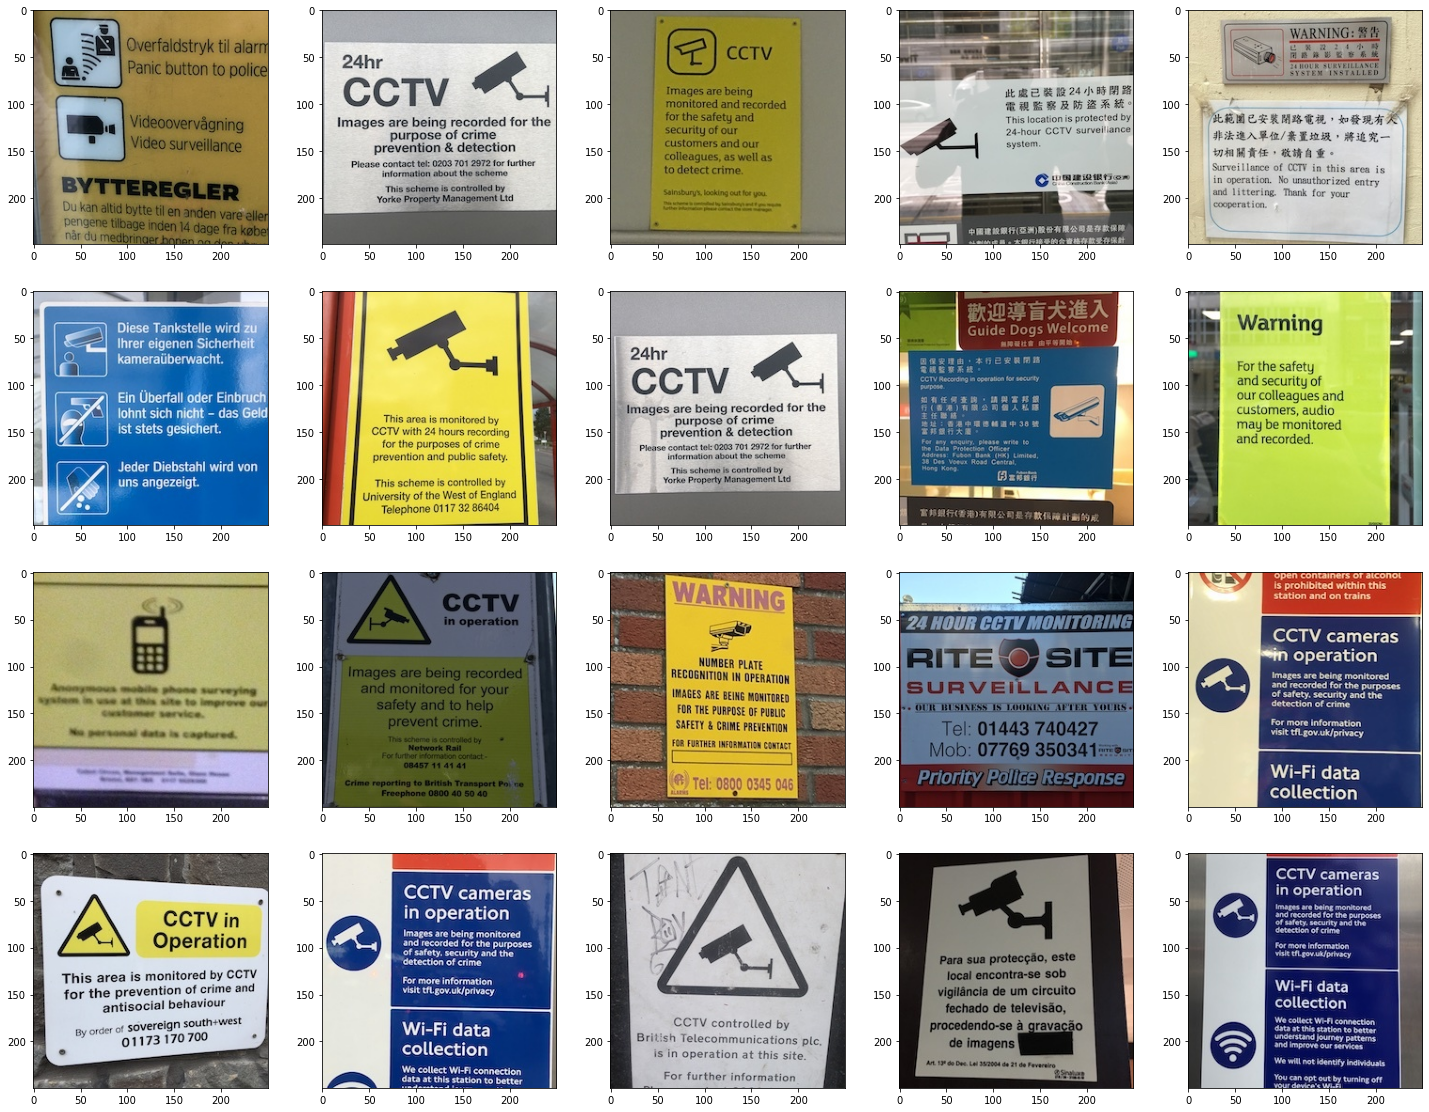

In [53]:
image_gallery_from_list(df_rough, 20)

In [54]:
print("The conservative approach detects {} images, the middle approach {} and the rough approach {}."\
      .format(len(df_conservative), len(df_middle), len(df_rough)))

The conservative approach detects 499 images, the middle approach 231 and the rough approach 105.


## Cleaning analysis
After inspecting each approach, the following has been observed

(1): The conservative approach contains some images that have a lot text in them, but there are also a lot of images that have not that much text and a clear camera logo in them. Using this approach for cleaning, could result in the removal of possible good training data.

(2): The middle approach contains images with quite some text in them and camera logos are often very small, compared to the rest of the sign. Most likely, due to the increase in frequency of text, the sign has less space for a clear camera logo. There are also a lot images in this approach, that have no camera logo at all in them.

(3): The rough approach contains mostly images with a lot of text in them and often have no camera logo in them. If there is a camera logo, it often is very small and simple.

After these observations, it has been decided to remove all the images that fall into the middle approach threshold. After this removal, there is more than enough training data still available, and a lot of bad training data has been removed.

## Cleaned dataset 

In [62]:
middle = df_middle['file_Name'].tolist()
resolution = df_250['file_Name'].tolist()
df = df[~df['file_Name'].isin(middle)]
df = df[~df['file_Name'].isin(resolution)]
final_df = df.reset_index(drop=True)
final_df

file_Name  width  heigth  channels
0     signs- 1178.jpg    250     250         3
1     signs- 1410.jpg    250     250         3
2     signs- 1411.jpg    250     250         3
3     signs- 1798.jpg    250     250         3
4     signs- 1799.jpg    250     250         3
...               ...    ...     ...       ...
1571   signs- 178.jpg    250     250         3
1572   signs- 179.jpg    250     250         3
1573   signs- 180.jpg    250     250         3
1574   signs- 181.jpg    250     250         3
1575   signs- 182.jpg    250     250         3

[1576 rows x 4 columns]

In [71]:
# Function to collect images to final folder
def save_to_folder(dataframe):
    new_list = dataframe['file_Name'].tolist()
    for filename in os.listdir(new_folder_path):
        if filename in new_list:
            if filename.endswith(".jpg"):
                img = cv2.imread(os.path.join(new_folder_path, filename))
                if img is not None:
                    cv2.imwrite(os.path.join(cleaned_path , filename), img)

In [72]:
save_to_folder(final_df)